In [8]:
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pywt
import numpy as np

In [9]:
# 小波系数管理类
class CoeChannels:
    def __init__(self, level):
        self.level = level 
        
        self.Ychannel = [[] for _ in range(level)]
        self.Ychannel.insert(0, None)                # [None(直流分量）, []第一级交流分量, []...]
        
        self.Cbchannel = [[] for _ in range(level)]
        self.Cbchannel.insert(0, None)
        
        self.Crchannel = [[] for _ in range(level)]
        self.Crchannel.insert(0, None)
        
        self.yIDWT = [[], ()]
        self.cbIDWT = [[], ()]
        self.crIDWT = [[], ()]
        
    def SetYchannel(self, coes):
        
        self.Ychannel = [[] for _ in range(self.level)]
        self.Ychannel.insert(0, None) 
        
        self.Ychannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Ychannel[i+1].append(coeItem)
                print("Y:", coes[i+1][j].shape)
                
    def SetCbchannel(self, coes):
        
        self.Cbchannel = [[] for _ in range(self.level)]
        self.Cbchannel.insert(0, None) 
        
        self.Cbchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Cbchannel[i+1].append(coeItem)
                print("Cb:", coes[i+1][j].shape)
                
    def SetCrchannel(self, coes):
        
        self.Crchannel = [[] for _ in range(self.level)]
        self.Crchannel.insert(0, None) 
        
        self.Crchannel[0] = CoefficientItem(coes[0])
        for i in range(self.level):
            for j in range(3):
                coeItem = CoefficientItem(coes[i+1][j])
                self.Crchannel[i+1].append(coeItem)
                print("Cr:", coes[i+1][j].shape)
                
    def AssembleAllChannelsForIDWT(self):
        # 重新组合全部通道的系数，为了进行离散小波逆变换
        if self.level != 1:
            raise ValueError("此函数仅支持组合级数为1的小波变换系数")
        self.yIDWT = [self.Ychannel[0].IquantArray, (self.Ychannel[1][0].IquantArray,
                                                    self.Ychannel[1][1].IquantArray,
                                                    self.Ychannel[1][2].IquantArray,)]
        
        self.cbIDWT = [self.Cbchannel[0].IquantArray, (self.Cbchannel[1][0].IquantArray,
                                                    self.Cbchannel[1][1].IquantArray,
                                                    self.Cbchannel[1][2].IquantArray,)]
        
        self.crIDWT = [self.Crchannel[0].IquantArray, (self.Crchannel[1][0].IquantArray,
                                                    self.Crchannel[1][1].IquantArray,
                                                    self.Crchannel[1][2].IquantArray,)]
        
        return self
    
    def ConstraintCoeItemsToZero(self, factor):
        
        
        t = self.Ychannel[0].originalArray
        a = t < t.max() / factor
        b = t > t.min() / factor
        t[a & b] = 0
        self.Ychannel[0].originalArray = t
        t = self.Cbchannel[0].originalArray
        a = t < t.max() / factor
        b = t > t.min() / factor
        t[a & b] = 0
        self.Cbchannel[0].originalArray = t
        t = self.Crchannel[0].originalArray
        a = t < t.max() / factor
        b = t > t.min() / factor
        t[a & b] = 0
        self.Crchannel[0].originalArray = t
        for i in range(self.level):
            for j in range(3):
                t = self.Ychannel[i+1][j].originalArray
                a = t < t.max() / factor
                b = t > t.min() / factor
                t[a & b] = 0
                self.Ychannel[i+1][j].originalArray = t
                t = self.Cbchannel[i+1][j].originalArray
                a = t < t.max() / factor
                b = t > t.min() / factor
                t[a & b] = 0
                self.Cbchannel[i+1][j].originalArray = t
                t = self.Crchannel[i+1][j].originalArray
                a = t < t.max() / factor
                b = t > t.min() / factor
                t[a & b] = 0
                self.Crchannel[i+1][j].originalArray = t
                
        self.RecaculateAllItems()
    
    def RecaculateAllItems(self):
        self.Ychannel[0].RecalculateAllArray()
        self.Cbchannel[0].RecalculateAllArray()
        self.Crchannel[0].RecalculateAllArray()
        for i in range(self.level):
            for j in range(3):
                self.Ychannel[i+1][j].RecalculateAllArray()
                self.Cbchannel[i+1][j].RecalculateAllArray()
                self.Crchannel[i+1][j].RecalculateAllArray()
    
    def AssembleAndCalulateIDWT_2levels(self, bias):
        result = []
        pic = np.dstack((self.Ychannel[0].IquantArray, 
                 self.Cbchannel[0].IquantArray, 
                 self.Crchannel[0].IquantArray )) + bias
        
        temp = pic / pic.max() * 255
        temp[temp > 255] = 255
        pic = np.uint8(temp)
        img0 = Image.fromarray(pic, mode="RGB").convert("RGB")
        result.append(img0)
        
        iy = self.Ychannel[0].IquantArray
        ib = self.Cbchannel[0].IquantArray
        ir = self.Crchannel[0].IquantArray
        
        for i in range(self.level):
              
            self.yIDWT = [iy, (self.Ychannel[i+1][0].IquantArray,
                                                        self.Ychannel[i+1][1].IquantArray,
                                                        self.Ychannel[i+1][2].IquantArray,)]

            self.cbIDWT = [ib, (self.Cbchannel[i+1][0].IquantArray,
                                                        self.Cbchannel[i+1][1].IquantArray,
                                                        self.Cbchannel[i+1][2].IquantArray,)]

            self.crIDWT = [ir, (self.Crchannel[i+1][0].IquantArray,
                                                        self.Crchannel[i+1][1].IquantArray,
                                                        self.Crchannel[i+1][2].IquantArray,)]
            iy = pywt.waverec2(self.yIDWT, "db2", mode="periodization")
            ib = pywt.waverec2(self.cbIDWT, "db2", mode="periodization")
            ir = pywt.waverec2(self.crIDWT, "db2", mode="periodization")

            print(iy.min(), ib.min(), ir.min())
            print(iy.max(), ib.max(), ir.max())

            pic = np.dstack(((iy), (ib), (ir))) + bias * (self.level - i)
            
            temp = pic / pic.max() * 255
            temp[temp > 255] = 255
            pic = np.uint8(temp)
            
            # pic = np.dstack(((iy), (ib), (ir))) + bias
            # pic = np.uint8(pic)

            img1 = Image.fromarray(pic, mode="RGB").convert("RGB")
            
            result.append(img1)
   
        return result

# 小波系数类
class CoefficientItem:
    def __init__(self, originalArray):
        self.maxV = 0
        self.minV = 0
        self.delta = 0
        self.originalArray = None
        self.quantArray = None
        self.IquantArray = None
        
        self.originalArray = originalArray
        self.maxV = int(originalArray.max())
        self.minV = int(originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + 1*self.minV
        
        
    def RecalculateIquantArray(self):
        self.IquantArray = self.quantArray * self.delta + self.minV
        
    def RecalculateAllArray(self):
        self.maxV = int(self.originalArray.max())
        self.minV = int(self.originalArray.min())
        self.delta = (self.maxV - self.minV) / 255
        
        t = (self.originalArray - self.minV) / self.delta
        t[t > 255] = 255
        self.quantArray = np.uint8(t)
        self.IquantArray = self.quantArray * self.delta + self.minV

In [10]:
# 图像类
class DNAImage:
    def __init__(self, image:Image):
        self.image = image
        self.level = 0
        self.shape = None
        self.RGB_array = None          # RGB通道图像矩阵 维度（x, y, 3)
        self.RGB_img = None
        self.YCbCr_array = None
        self.YCbCr_img = None
        
        self.coeChannels = None # 存储小波变换系数的三通道列表 【Y， Cb， Cr】

        self.info_init()
        
    def info_init(self):
        self.RGB_img = self.image.convert("YCbCr")#.resize((96, 54))
        self.YCbCr_img = self.image.convert("RGB")#.resize((16*20, 9*20))
        self.RGB_array = np.array(self.RGB_img)
        self.YCbCr_array = np.array(self.YCbCr_img)
        
        # DC平移
        self.YCbCr_array = np.int16(self.YCbCr_array)
        #self.YCbCr_array -= 128

        
        print(self.YCbCr_array.shape)
        return self
        
    def DWT(self, level):
        self.level = level
        self.coeChannels = CoeChannels(level)
        Yc = pywt.wavedec2(self.YCbCr_array[:,:,0], 'db2', mode="periodization", level=level)
        Cbc = pywt.wavedec2(self.YCbCr_array[:,:,1], 'db2', mode="periodization", level=level)
        Crc = pywt.wavedec2(self.YCbCr_array[:,:,2], 'db2', mode="periodization", level=level)
        
        self.coeChannels.SetYchannel(Yc)
        self.coeChannels.SetCbchannel(Cbc)
        self.coeChannels.SetCrchannel(Crc)
        
        
        return self
    
    def show(self):
        plt.imshow(self.RGB_array/255)

# 小波逆变换之后进行反向DC偏移恢复原始图像

(2400, 4000, 3)
Y: (1200, 2000)
Y: (1200, 2000)
Y: (1200, 2000)
Cb: (1200, 2000)
Cb: (1200, 2000)
Cb: (1200, 2000)
Cr: (1200, 2000)
Cr: (1200, 2000)
Cr: (1200, 2000)


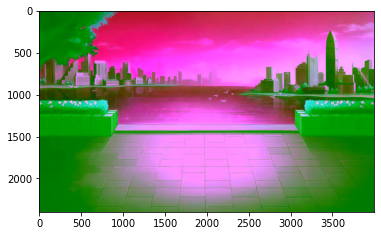

In [11]:
dna = DNAImage(Image.open("4.jpg"))
t = dna.DWT(1).coeChannels.AssembleAllChannelsForIDWT()
print(t.Ychannel[1][2].quantArray.flat)
#print(np.bincount(t.Ychannel[1][2].quantArray.flat))
iy = pywt.waverec2(t.yIDWT, "db2", mode="periodization")
ib = pywt.waverec2(t.cbIDWT, "db2", mode="periodization")
ir = pywt.waverec2(t.crIDWT, "db2", mode="periodization")

pic = np.dstack((np.uint8(iy), np.uint8(ib), np.uint8(ir)))
img = Image.fromarray(pic, mode="YCbCr").convert("RGB")
plt.imshow(img)

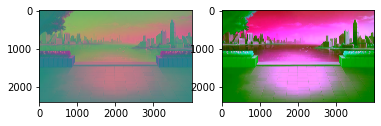

In [12]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(dna.RGB_array)
ax[1].imshow(img)
f.savefig("www.png")

# YCbCr空间的多级分辨率预览操作

7195.0


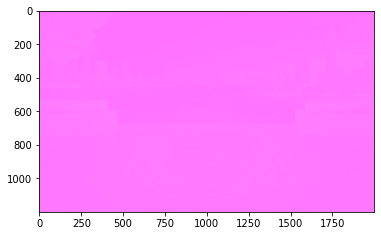

In [13]:
bias = 7200
pic = np.dstack((dna.coeChannels.Ychannel[0].IquantArray, 
                 dna.coeChannels.Cbchannel[0].IquantArray, 
                 dna.coeChannels.Crchannel[0].IquantArray )) + bias

print(pic.min())
pic = np.uint8(pic / pic.max() * 255)
img = Image.fromarray(pic, mode="YCbCr").convert("RGB")
plt.imshow(np.array(img))
# plt.imshow(dna.YCbCr_array[:, :, 2])
# img = Image.fromarray(dna.YCbCr_array, mode="YCbCr").convert("RGB")
# plt.imshow(img)

In [14]:
dna = DNAImage(Image.open("2.jpg"))
t = dna.DWT(2).coeChannels

(668, 1000, 3)
Y: (167, 250)
Y: (167, 250)
Y: (167, 250)
Y: (334, 500)
Y: (334, 500)
Y: (334, 500)
Cb: (167, 250)
Cb: (167, 250)
Cb: (167, 250)
Cb: (334, 500)
Cb: (334, 500)
Cb: (334, 500)
Cr: (167, 250)
Cr: (167, 250)
Cr: (167, 250)
Cr: (334, 500)
Cr: (334, 500)
Cr: (334, 500)


# 多级小波变换输出测试

(2400, 4000, 3)
Y: (600, 1000)
Y: (600, 1000)
Y: (600, 1000)
Y: (1200, 2000)
Y: (1200, 2000)
Y: (1200, 2000)
Cb: (600, 1000)
Cb: (600, 1000)
Cb: (600, 1000)
Cb: (1200, 2000)
Cb: (1200, 2000)
Cb: (1200, 2000)
Cr: (600, 1000)
Cr: (600, 1000)
Cr: (600, 1000)
Cr: (1200, 2000)
Cr: (1200, 2000)
Cr: (1200, 2000)
24.862986444877922 10.565046816289797 -6.329973494694132
528.4540074928435 523.0780014385182 520.463220310941
3.646660420379238 3.835168354678771 -0.9356878496537551
256.1080160735196 276.24892880673275 255.29631628757355


<Figure size 5760x2880 with 0 Axes>

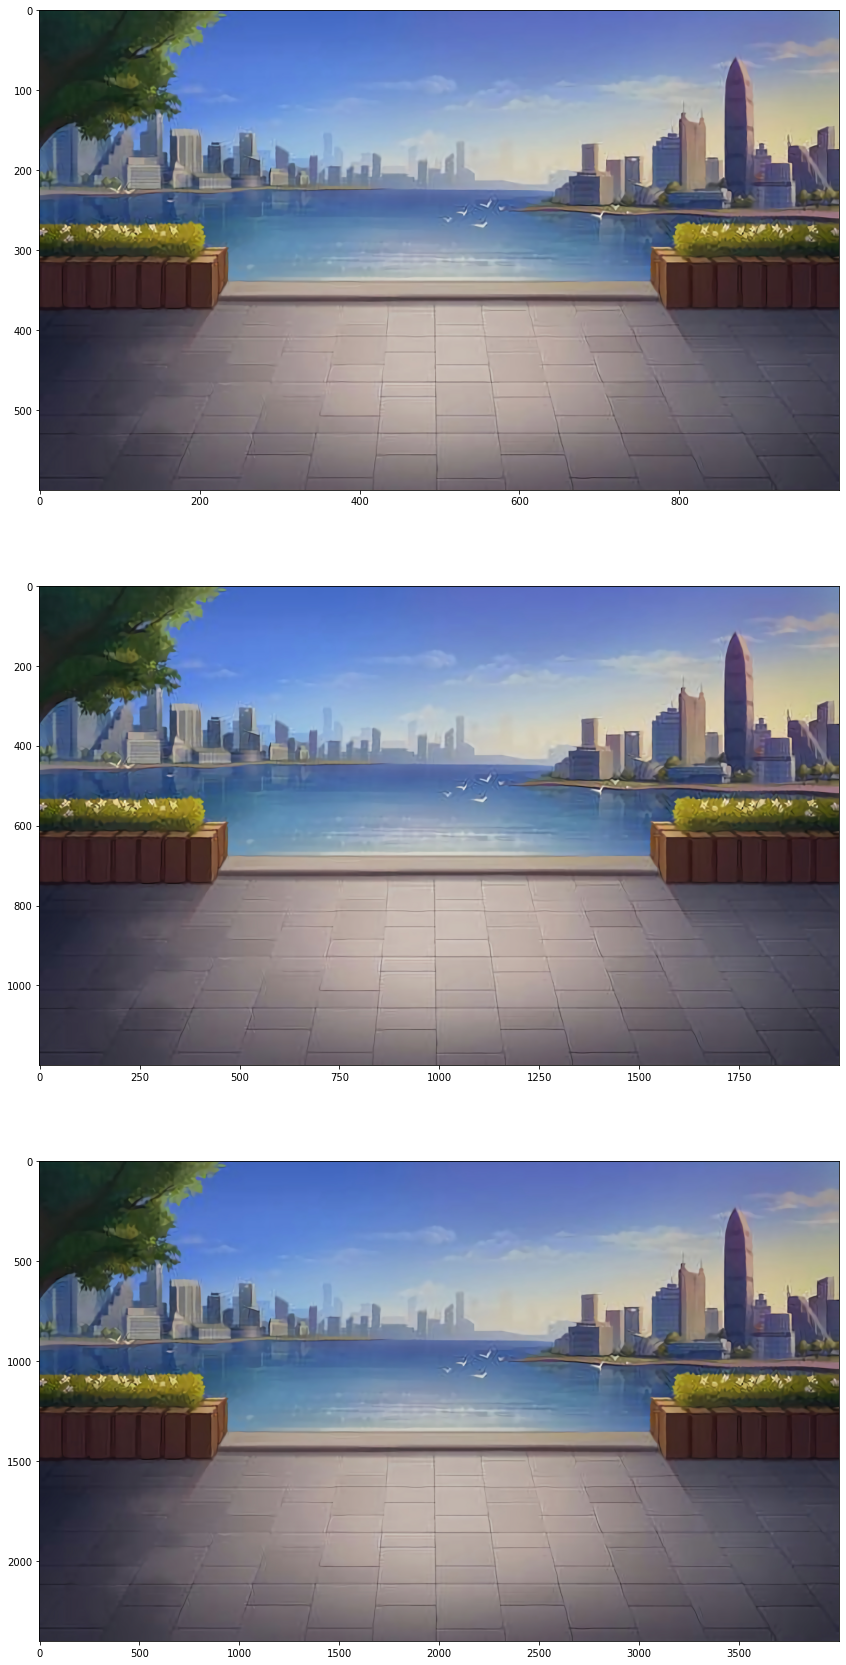

In [15]:

dna = DNAImage(Image.open("4.jpg"))
imgs = dna.DWT(2).coeChannels.AssembleAndCalulateIDWT_2levels(0)
plt.figure(figsize=(80,40)) 
f, ax = plt.subplots(len(imgs), 1, figsize=(50, 30))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
f.savefig("www.png")

# 小波系数量化后编码

(2276, 1280, 3)
Y: (36, 20)
Y: (36, 20)
Y: (36, 20)
Y: (72, 40)
Y: (72, 40)
Y: (72, 40)
Y: (143, 80)
Y: (143, 80)
Y: (143, 80)
Y: (285, 160)
Y: (285, 160)
Y: (285, 160)
Y: (569, 320)
Y: (569, 320)
Y: (569, 320)
Y: (1138, 640)
Y: (1138, 640)
Y: (1138, 640)
Cb: (36, 20)
Cb: (36, 20)
Cb: (36, 20)
Cb: (72, 40)
Cb: (72, 40)
Cb: (72, 40)
Cb: (143, 80)
Cb: (143, 80)
Cb: (143, 80)
Cb: (285, 160)
Cb: (285, 160)
Cb: (285, 160)
Cb: (569, 320)
Cb: (569, 320)
Cb: (569, 320)
Cb: (1138, 640)
Cb: (1138, 640)
Cb: (1138, 640)
Cr: (36, 20)
Cr: (36, 20)
Cr: (36, 20)
Cr: (72, 40)
Cr: (72, 40)
Cr: (72, 40)
Cr: (143, 80)
Cr: (143, 80)
Cr: (143, 80)
Cr: (285, 160)
Cr: (285, 160)
Cr: (285, 160)
Cr: (569, 320)
Cr: (569, 320)
Cr: (569, 320)
Cr: (1138, 640)
Cr: (1138, 640)
Cr: (1138, 640)
1556.579116508099 1900.843727398864 1861.5270565390704
7803.026444042489 7833.5377778895745 7732.841650053669
672.8908893566962 826.8100566824824 906.049911106531
4191.084273053925 4193.18486126233 4114.56940527045
320.389671123

array([[ 190.20520973,    0.        ,    0.        , ...,    0.        ,
         193.06635364,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , -305.45885538, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

<Figure size 5760x2880 with 0 Axes>

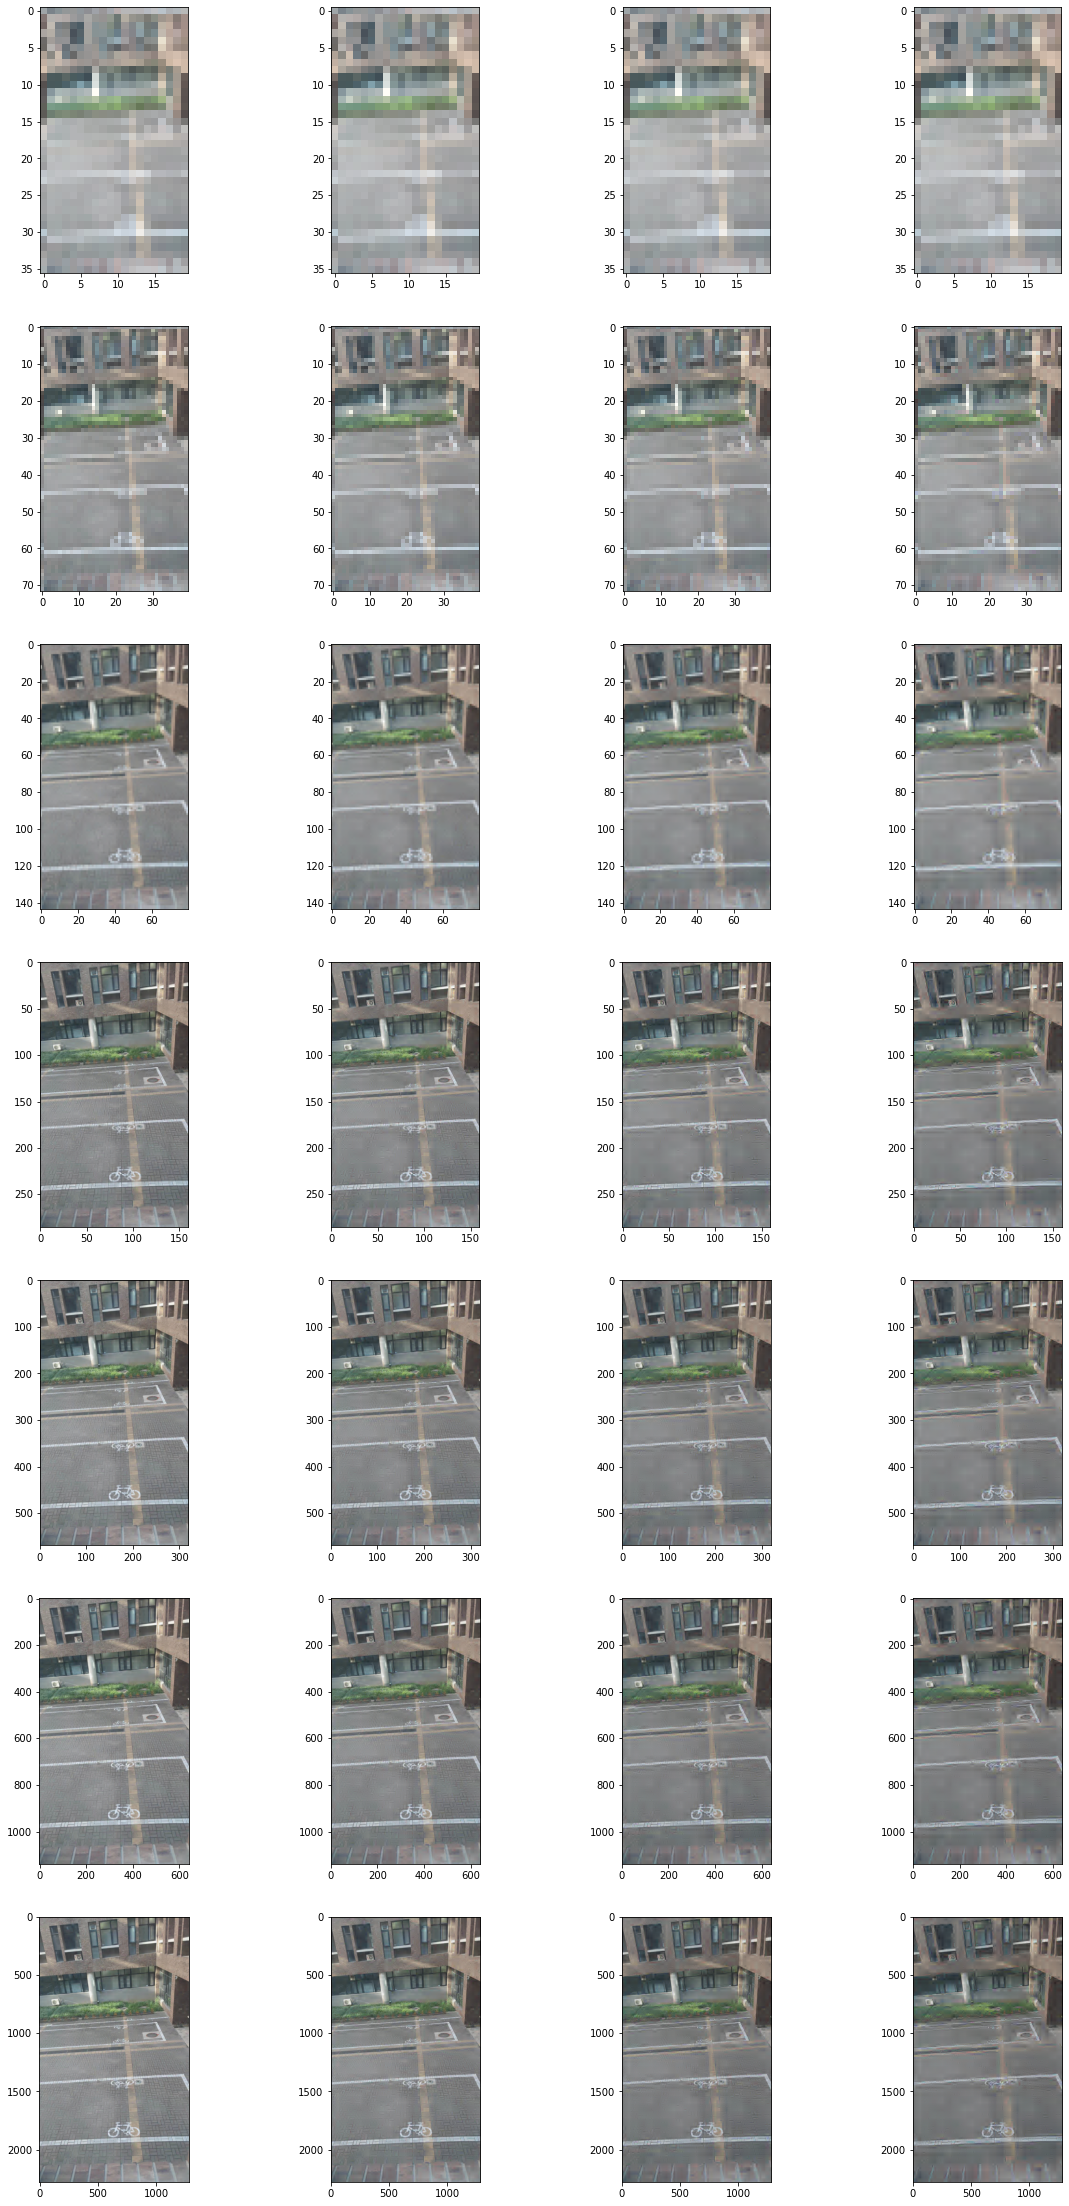

In [16]:
dna = DNAImage(Image.open("a.jpg"))
t = dna.DWT(6)
t.coeChannels.ConstraintCoeItemsToZero(20)

img_list = []
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(10)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(6)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)

t.coeChannels.ConstraintCoeItemsToZero(4)
imgs = t.coeChannels.AssembleAndCalulateIDWT_2levels(0)
img_list.append(imgs)


#print(t.coeChannels.Ychannel[6][2].quantArray)
plt.figure(figsize=(80,40)) 
f, ax = plt.subplots(len(imgs), len(img_list), figsize=(20, 40))
for i in range(len(img_list)):
    for j in range(len(imgs)):
        ax[j][i].imshow(img_list[i][j])
        
f.savefig("www.png")
dna.coeChannels.Ychannel[2][2].originalArray

# 哈夫曼编码

## 二进制、十进制、ascii码转换函数

In [17]:
def DecToBin(num:int):
    result = []
    while(num // 2 != 0):
        result.append(str(num % 2))
        if(num // 2 !=0):
            num //= 2
    if num == 1:
        result.append("1")
    
    while(len(result) < 8):
        result.append("0")
    result.reverse()  
    return "".join(result)
    
def BinToDec(num:str):
    return int(num, 2)

def BinToChr(num:str):
    _ascii = int(num, 2)
    return chr(_ascii)
def ChrToBin(ch:str):
    asc = ord(ch)
    return DecToBin(asc)

## 系数矩阵转换成字符串及其反变换

In [18]:
def ArrayToBytes(array):
    print(array.shape)
    result = ""
    shape = array.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            result += chr(array[i][j])
    return result
def BytesToArray(seq, hei, wid):
    result = np.zeros((hei,wid ))
    assert(len(seq) == wid * hei)
    
    for i in range(hei):
        for j in range(wid):
            result[i][j] = BinToDec(ChrToBin(seq[i*wid + j]))
    
    return np.uint8(result)

## 游程编码

In [19]:
def RunLengthEncode(seq:str):
    # 游程编码  结构化格式，两字节为一组，第一个字节为个数，最大256（0000 0000 表示1） 第二个字节为数据
    result = ""
    now = seq[0]
    count = 1
    for i in range(1, len(seq)):
        if now == seq[i]:
            count += 1
            
            if count == 256 and i != len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(now)
                now = seq[i+1]
                count = 0
                continue
            elif count == 256 and i == len(seq)-1:
                result += DecToBin(count-1) + ChrToBin(seq[i])
                break
        else: 
            result += DecToBin(count-1) + ChrToBin(now)
            now = seq[i]
            count = 1
        if i == len(seq)-1: 
            result += DecToBin(count-1) + ChrToBin(seq[i])
    print("原始比特长度：" + str(len(seq) * 8) + "  编码后比特长度：" + str(len(result)) + "  压缩率：" + str((len(seq) * 8 - len(result)) / (len(seq) * 8)))
    return result

def RunLengthDecode(seq:str):
    # 游程解码
    blocks_count = len(seq) // 16
    result = ""
    for i in range(blocks_count):
        content = seq[16*i : 16*(i+1)]
        print(content)
        count = BinToDec(content[:8]) + 1
        char = BinToChr(content[8:])
        for j in range(count):
            result += char
    return result

## 游程编码解码，系数矩阵编码解码还原测试

In [ ]:
from reedsolo import RSCodec

In [1]:
ori = ArrayToBytes(dna.coeChannels.Ychannel[2][0].quantArray)
enc = RunLengthEncode(ori)
dec = RunLengthDecode(enc)
print(dec)
assert(ori == dec)

recoveryArray = BytesToArray(dec, 36, 20)
for i in range(36):
    for j in range(20):
        if dna.coeChannels.Ychannel[0].quantArray[i][j] == recoveryArray[i][j]:
            continue
        else:
            print("ERROR")
            break

#ArrayToBytes(dna.coeChannels.Ychannel[0].quantArray)

NameError: name 'ArrayToBytes' is not defined

In [26]:

ecc=RSCodec(6)#纠错码字长度，可纠正n/2个误读
#编码
byte_msg=ecc.encode(dec.encode("utf-8")) #8个字符+6个纠错字=14字符=14*8位
print(byte_msg)
#转换为二进制
binary_code=''.join(format(x,'08b') for x in byte_msg)
print(len(binary_code),type(binary_code))
print(binary_code)
'''
bytearray(b'Bingo007\x7f\xadbG\x11\x9c')
112 <class 'str'>
0100001001101001011011100110011101101111001100000011000000110111011111111010110101100010010001110001000110011100
'''
#污染二进制
binary_code=list(binary_code)
binary_code[0*8+2]=str(1-int(binary_code[0*8+2]))
binary_code[1*8+4]=str(1-int(binary_code[1*8+4]))
binary_code[3*8+5]=str(1-int(binary_code[3*8+5]))
# binary_code[5*8+5]=str(1-int(binary_code[5*8+5]))#再错就无法纠正信息
binary_code=''.join(binary_code)
print(binary_code)
'''
0110001001100001011011100110001101101111001100000011000000110111011111111010110101100010010001110001000110011100
'''
#纠错
#先转换为bytearray形式
bytes_msg=bytes(int(binary_code[i:i+8],2) for i in range(0,len(binary_code),8))
array_msg=bytearray(bytes_msg)
#再纠错
data=ecc.decode(array_msg)
print('11111----',data)
msg=data[0].decode()
print(msg)

#Bingo007


bytearray(b'n\xc2\x9dnnnnn\xc2\xb2\xc2\xadnn\xc2\x9fn%#n4KCnnnnLA7nnnnnnnnn0nnnn\x00nnnnnnnnnnnnnnnnnnn\xc2\x93nnnnnnnnn,nnnn\xc3\xbf\xc3\xa3n\xc3\xb9nG7nnn\xc3\xae\xc2\xb0nn\xc2\xa3nnnnC\x11RnnnnnnI8nnnn;Pnnn\xc2\xa2nnn\xc2\x9dnn\xc2\xa6n\xc2\xa0\xc2\x97nnnnnnn\xc3\x90\xc2\xa2nn\xc2\xb4nnnnnn\xc2\xa5\xc2\xb4\xc2\xbc\xc2\xbb8nnnn5\x1fGnnn\xc2\x97n\xc2\xb0)5nK9>nAnnnnnnn.MnBOnnnnnnnnnnK+Lnnnnnnn\x17/Rnn\xc3\x86\xc2\xb2nnnnnnnnOnnnnno\xfa|lL\xe5\xc2\xb6\xc3\x85nn\xc2\x9b\xc2\xa4nOEn\xc2\x93\xc2\x9c\xc2\x96n\xc2\xadnnnnQLGLnn\xc2\x98\xc3\x87\xc2\xae\xc2\xa2\xc2\xa1\xc2\x9fPnn\x0fnnn\xc2\x96nnnnn-G>D,.3nnnnnnn8nnnn\xc2\xa0\xc2\x9bnnnnnnnnnnONN\xc2\xadnnnnnnnnnnnnnHnnnn\xc2\xb2nnnnnnnnnnMPnIOnnnnnn>nn\xc2\xa0\xc2\xbe\xc3\x94\xc3\x96\xc3\x8d\xc3\x91\xc2\x9fnnnH>nnnnn-@nnn\xc2\x94\xc2\x96\xc2\x9dnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnD:0HFEnnnn\xc2\xb8\xc3\x86\xc3\x93\xc3l\x06\xfa!#S\x8a\xc3\x96n\xc2\xb3\xc2\xb2\xc2\xa4\xc2\x99nnnnnnnnnnnnnnnnnnnnnnnnnnnHnnnnnnnnnnnnnnnnnnnnn

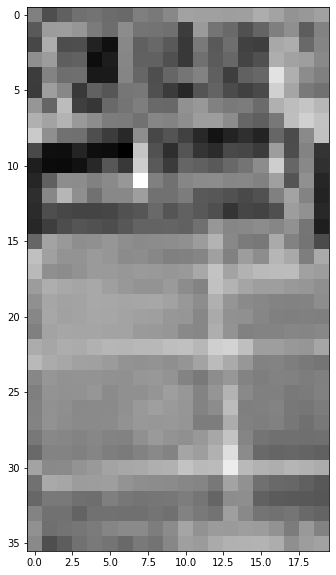

In [490]:
plt.figure(figsize=(20,10)) 
plt.imshow(dna.coeChannels.Ychannel[0].quantArray, cmap="gray")

In [601]:
dna.coeChannels.Ychannel[0].maxV

13783

In [605]:
print(np.int16(0b0000111111111111))

4095


# 封装系数帧 CoeDataFrame

In [ ]:
# [7bit 描述头 [D6D5 | 00 R 01 G 10 B, D4D3D2 000-111 小波级别, D1D0 00 LL 01 LH 10 HL 11 HH] ] 
# [16bit行数]  [16bit列数] [16bit int16 maxV]  [16bit int16 minV]  [2bit compress method( 01 游程 10 haffman 11 二者兼具)]  [1bit payload bit数是奇数还是偶数]
class CoeDataFrame:
    def __init__(self):
        